In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage
import cv2
import platform
import pathlib
import json
import scipy.io

from datasets import Dataset
from PIL import Image

from torch.utils.data import Dataset as torchDataset

In [6]:
# Function to plot each individual cell mask as a series of subplots
def plot_all_cells_in_mask(all_cells_in_mask_1): 
    np.set_printoptions(threshold=np.inf)
    num_cells = len(all_cells_in_mask_1)

    # Create subplots: adjust the grid size as needed
    cols = int(np.ceil(np.sqrt(num_cells)))  # For a square-ish layout
    rows = int(np.ceil(num_cells / cols))
    _, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

    for i, cell_mask in enumerate(all_cells_in_mask_1):
        ax = axs.flat[i]
        ax.imshow(cell_mask[0], cmap='gray')
        ax.axis('off')  # Hide axis

    for i in range(num_cells, rows*cols):
        axs.flat[i].axis('off')

    plt.show()

# Func to get all cells' position and store them in a list of tuples(x,y)
def get_all_cells_pos(all_cells_in_mask_1):
    all_cell_positions = []

    for cell in all_cells_in_mask_1:
        cell_position = cell[1]
        y_pos, x_pos = cell_position[0][0], cell_position[0][1]
        all_cell_positions.append((y_pos, x_pos))

    return all_cell_positions

def patch_cells_into_picture_inc(all_cells_in_mask_1, all_cell_positions):
    picture = np.zeros((2048, 2048), dtype=int)
    
    for cell_mask, pos in zip(all_cells_in_mask_1, all_cell_positions):
        mask = cell_mask[0]  # Extract the mask (assuming it's at index 0)
        if np.all(mask == 0):  # Skip if the mask is all zeros
            continue
        
        y_pos, x_pos = pos  # Extract the y and x positions
        mask_height, mask_width = mask.shape
        binary_mask = mask > 0
        y_end, x_end = min(y_pos + mask_height, 2048), min(x_pos + mask_width, 2048)
        picture[y_pos:y_end, x_pos:x_end] |= binary_mask[:y_end-y_pos, :x_end-x_pos]
    
    return picture

# Func to patch individual cell mask into a whole picture
def patch_cells_into_picture_exc(all_cells_in_mask_1, all_cell_positions):
    picture = np.zeros((2048, 2048), dtype=int)
    
    for cell_mask, pos in zip(all_cells_in_mask_1, all_cell_positions):
        mask = cell_mask[0]  # Extract the mask (assuming it's at index 0)
        if np.all(mask == 0):  # Skip if the mask is all zeros
            continue
        
        y_pos, x_pos = pos  # Extract the y and x positions
        mask_height, mask_width = mask.shape
        binary_mask = mask > 0
        y_end, x_end = min(y_pos + mask_height, 2048), min(x_pos + mask_width, 2048)
        picture[y_pos:y_end, x_pos:x_end] |= binary_mask[:y_end-y_pos, :x_end-x_pos]
    
    # Check if the picture is all zeros after processing all cells
    if np.all(picture == 0):
        return None  # Or any other indicator that signifies an empty picture
    
    return picture

# Func to load data from a .mat file and store it in a dictionary
def load_matlab_data(mat_file):
    file = pathlib.Path(mat_file)
    mat = scipy.io.loadmat(file)
    return mat

# Func to convert the frames into a list of dictionaries
def convert(all_frames):
    converted: list[dict] = []
    for i in range(all_frames.shape[0]):
        cur = dict()
        # use try catch to avoid error on edge cases
        try:
            for j in range(100):
                cur[j] = all_frames[i][0,0][j][0]
        except IndexError:
            pass
        converted.append(cur)
    return converted

# Func to get all the cells from a single frame and store them in a list of lists
def getCellsField(singleFrame, cellsInfoIndex=12):
    keys = list(singleFrame.keys())
    cell_data = None
    for i in range(len(keys)):
        buffer = singleFrame[keys[i]]
        if buffer.shape != () and buffer.shape[0] != 1:
            cell_data = buffer
    
    # Check if cell_data itself is directly accessible or if we need to iterate over it
    if not isinstance(cell_data, list) and not hasattr(cell_data, '__iter__'):
        # If cell_data is neither list nor iterable, it's not structured as expected
        return []

    cells = []
    for i in range(len(cell_data)):
        info = []
        try:
            # Attempt to access nested structure if it exists
            # Adjust access pattern based on your data's structure
            cell = cell_data[i][0,0] if hasattr(cell_data[i], 'size') and cell_data[i].size > 0 else None
            if cell is None:
                continue  # Skip if cell is None or doesn't have the expected structure
            
            for j in range(min(cellsInfoIndex, len(cell))):
                info.append(cell[j])
        except (TypeError, IndexError) as e:
            # Handle cases where cell_data[i] does not support indexing or is out of bounds
            continue
        
        if info:  # Only append if info is not empty
            cells.append(info)
    
    return cells

def show_mat_data(mat, cols, dir_name):
    mat = load_matlab_data(mat)
    all_frames = mat[dir_name][0] # all the masks corresponding to 101 tifs
    all_frames_converted = convert(all_frames)
    all_masks = []
    mask_index = []
    for i in range(len(all_frames_converted)):
        mask = all_frames_converted[i]
        all_cells_in_mask = getCellsField(mask)
        all_cell_positions = get_all_cells_pos(all_cells_in_mask)
        picture = patch_cells_into_picture_exc(all_cells_in_mask, all_cell_positions)   
        all_masks.append(picture) if picture is not None else None
        mask_index.append(i) if picture is not None else None

    plot_all(all_masks, cols, mask_index)

# Func to plot all the masks or pictures in a list
def plot_all(all, cols, mask_name):
    # Determine the number of masks
    num_masks = len(all)

    # Define the number of columns for subplots
    rows = num_masks // cols + (num_masks % cols > 0)

    # Create a figure to hold the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))  # Adjust figsize as needed

    # Flatten the axes array for easy indexing if it's 2D (when rows > 1)
    if num_masks > 1:
        axs = axs.flatten()

    for i in range(num_masks):
        # Plot each mask
        ax = axs[i] if num_masks > 1 else axs
        ax.imshow(all[i], cmap='gray')
        ax.axis('off')  # Hide axis
        ax.set_title(f'Mask {mask_name[i]}')

    # Hide any unused subplots
    if num_masks > 1:
        for j in range(i+1, rows*cols):
            axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Func to plot A mask on A tif image
def plot_mask_on_image(image, mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title('Overlay of Image and Mask')
    plt.show()

# Func to plot ALL the masks on ALL images
def plot_all_masks_on_all_images(all_images, all_masks, cols, mask_index):
    # Determine the number of images
    num_images = len(all_images)

    # Define the number of columns for subplots
    rows = num_images // cols + (num_images % cols > 0)

    # Create a figure to hold the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))  # Adjust figsize as needed

    # Flatten the axes array for easy indexing if it's 2D (when rows > 1)
    if num_images > 1:
        axs = axs.flatten()

    for i in range(num_images):
        # Plot each mask
        ax = axs[i] if num_images > 1 else axs
        ax.imshow(all_images[i], cmap='gray')
        ax.imshow(all_masks[i], cmap='jet', alpha=0.5)
        ax.axis('off')  # Hide axis
        ax.set_title(f'Mask {mask_index[i]}')

    # Hide any unused subplots
    if num_images > 1:
        for j in range(i+1, rows*cols):
            axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# New 4-5-2024
# Func to return all tiffs in the folder as a 3D numpy array (num_images, height, width)
def get_tiffs_from_folder(folder_name):
     # folder name
    file_names = os.listdir(folder_name)
    tiff_files = [file for file in file_names if file.endswith('.tif') or file.endswith('.tiff')]
    tiff_files.sort()
    images = [tifffile.imread(os.path.join(folder_name, file)) for file in tiff_files]
    images_array = np.array(images)
    return images_array

# Func to return all masks in the mat file as a list
def get_masks_from_mat(mat_file, dir_name):
    mat = load_matlab_data(mat_file)
    all_frames = mat[dir_name][0] # all the masks corresponding to 101 tifs
    all_frames_converted = convert(all_frames)
    all_masks = []
    mask_index = []
    for i in range(len(all_frames_converted)):
        mask = all_frames_converted[i]
        all_cells_in_mask = getCellsField(mask)
        all_cell_positions = get_all_cells_pos(all_cells_in_mask)
        picture = patch_cells_into_picture_exc(all_cells_in_mask, all_cell_positions)   
        all_masks.append(picture) if picture is not None else None
        mask_index.append(i) if picture is not None else None
    
    all_masks = np.array(all_masks)
    return all_masks, mask_index

In [7]:
mat_1_50 = load_matlab_data('1-50_Hong/1-50_finished.mat')

In [8]:
print(f".mat titles cnt: {len(mat_1_50.keys())}")
print(f"segmented frames cnt: {mat_1_50.keys()}")
print(mat_1_50['Tracked'].shape[1])

.mat titles cnt: 4
segmented frames cnt: dict_keys(['__header__', '__version__', '__globals__', 'Tracked'])
50


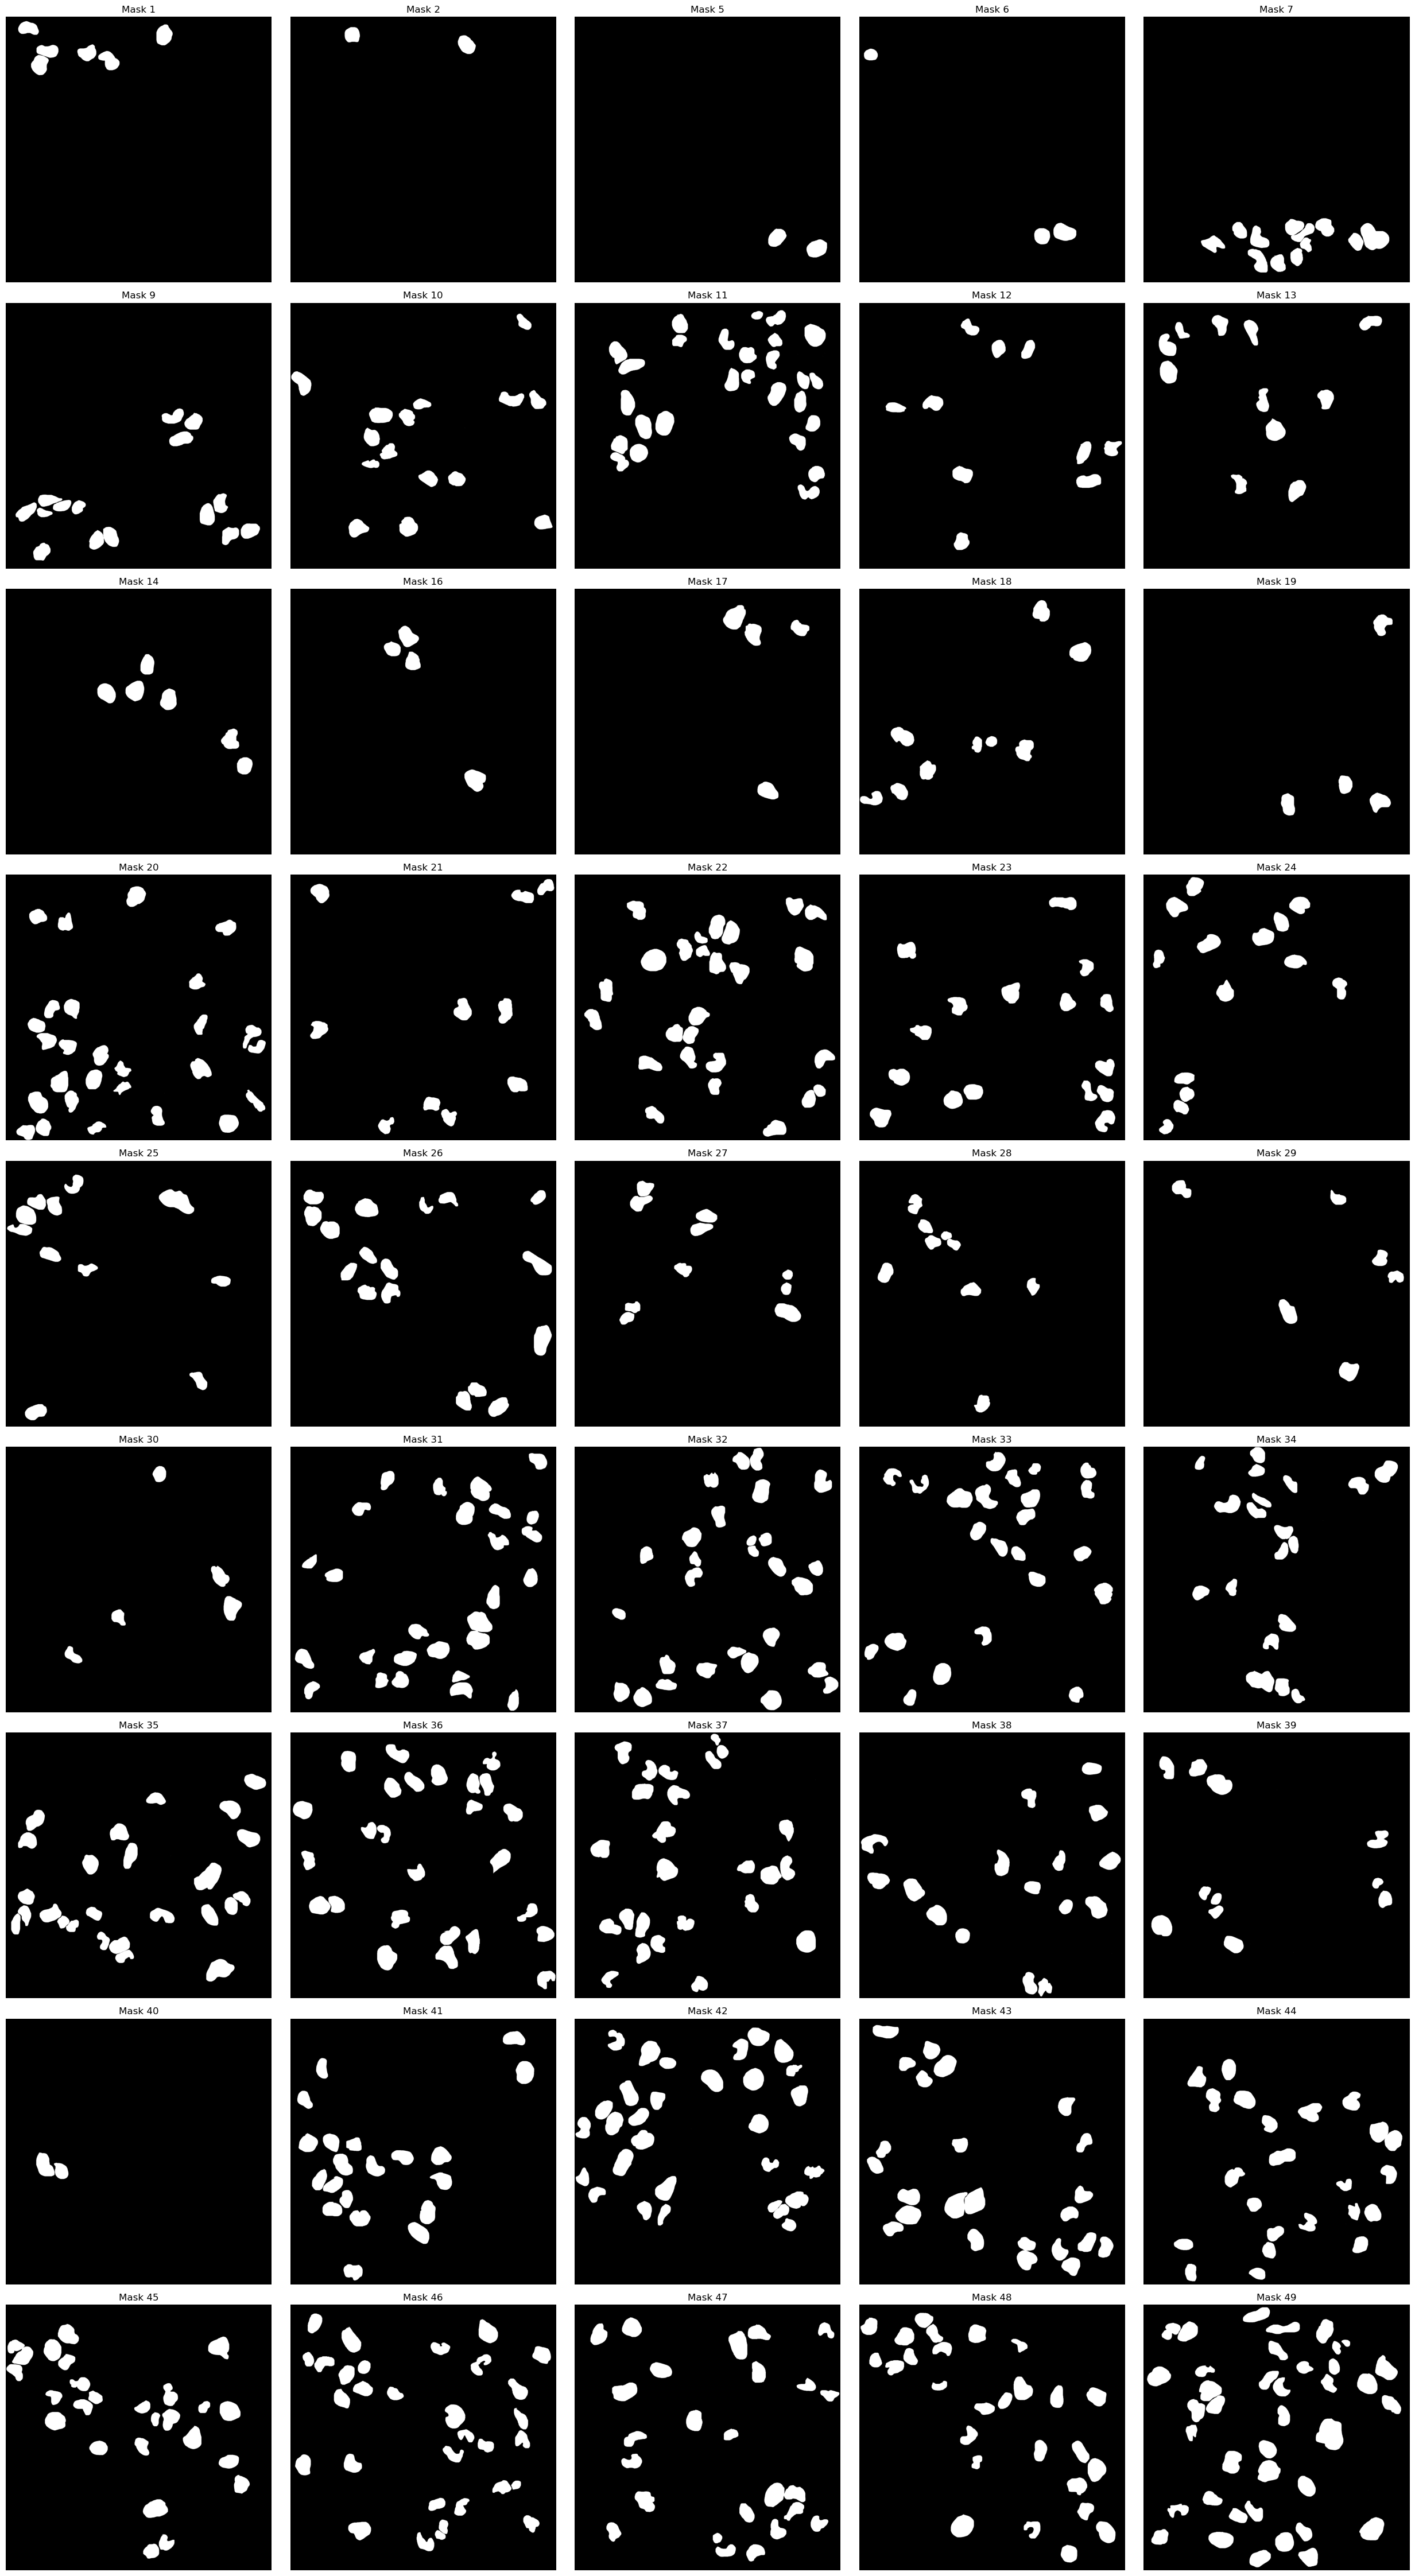

In [9]:
show_mat_data('1-50_Hong/1-50_finished.mat', 5, 'Tracked')

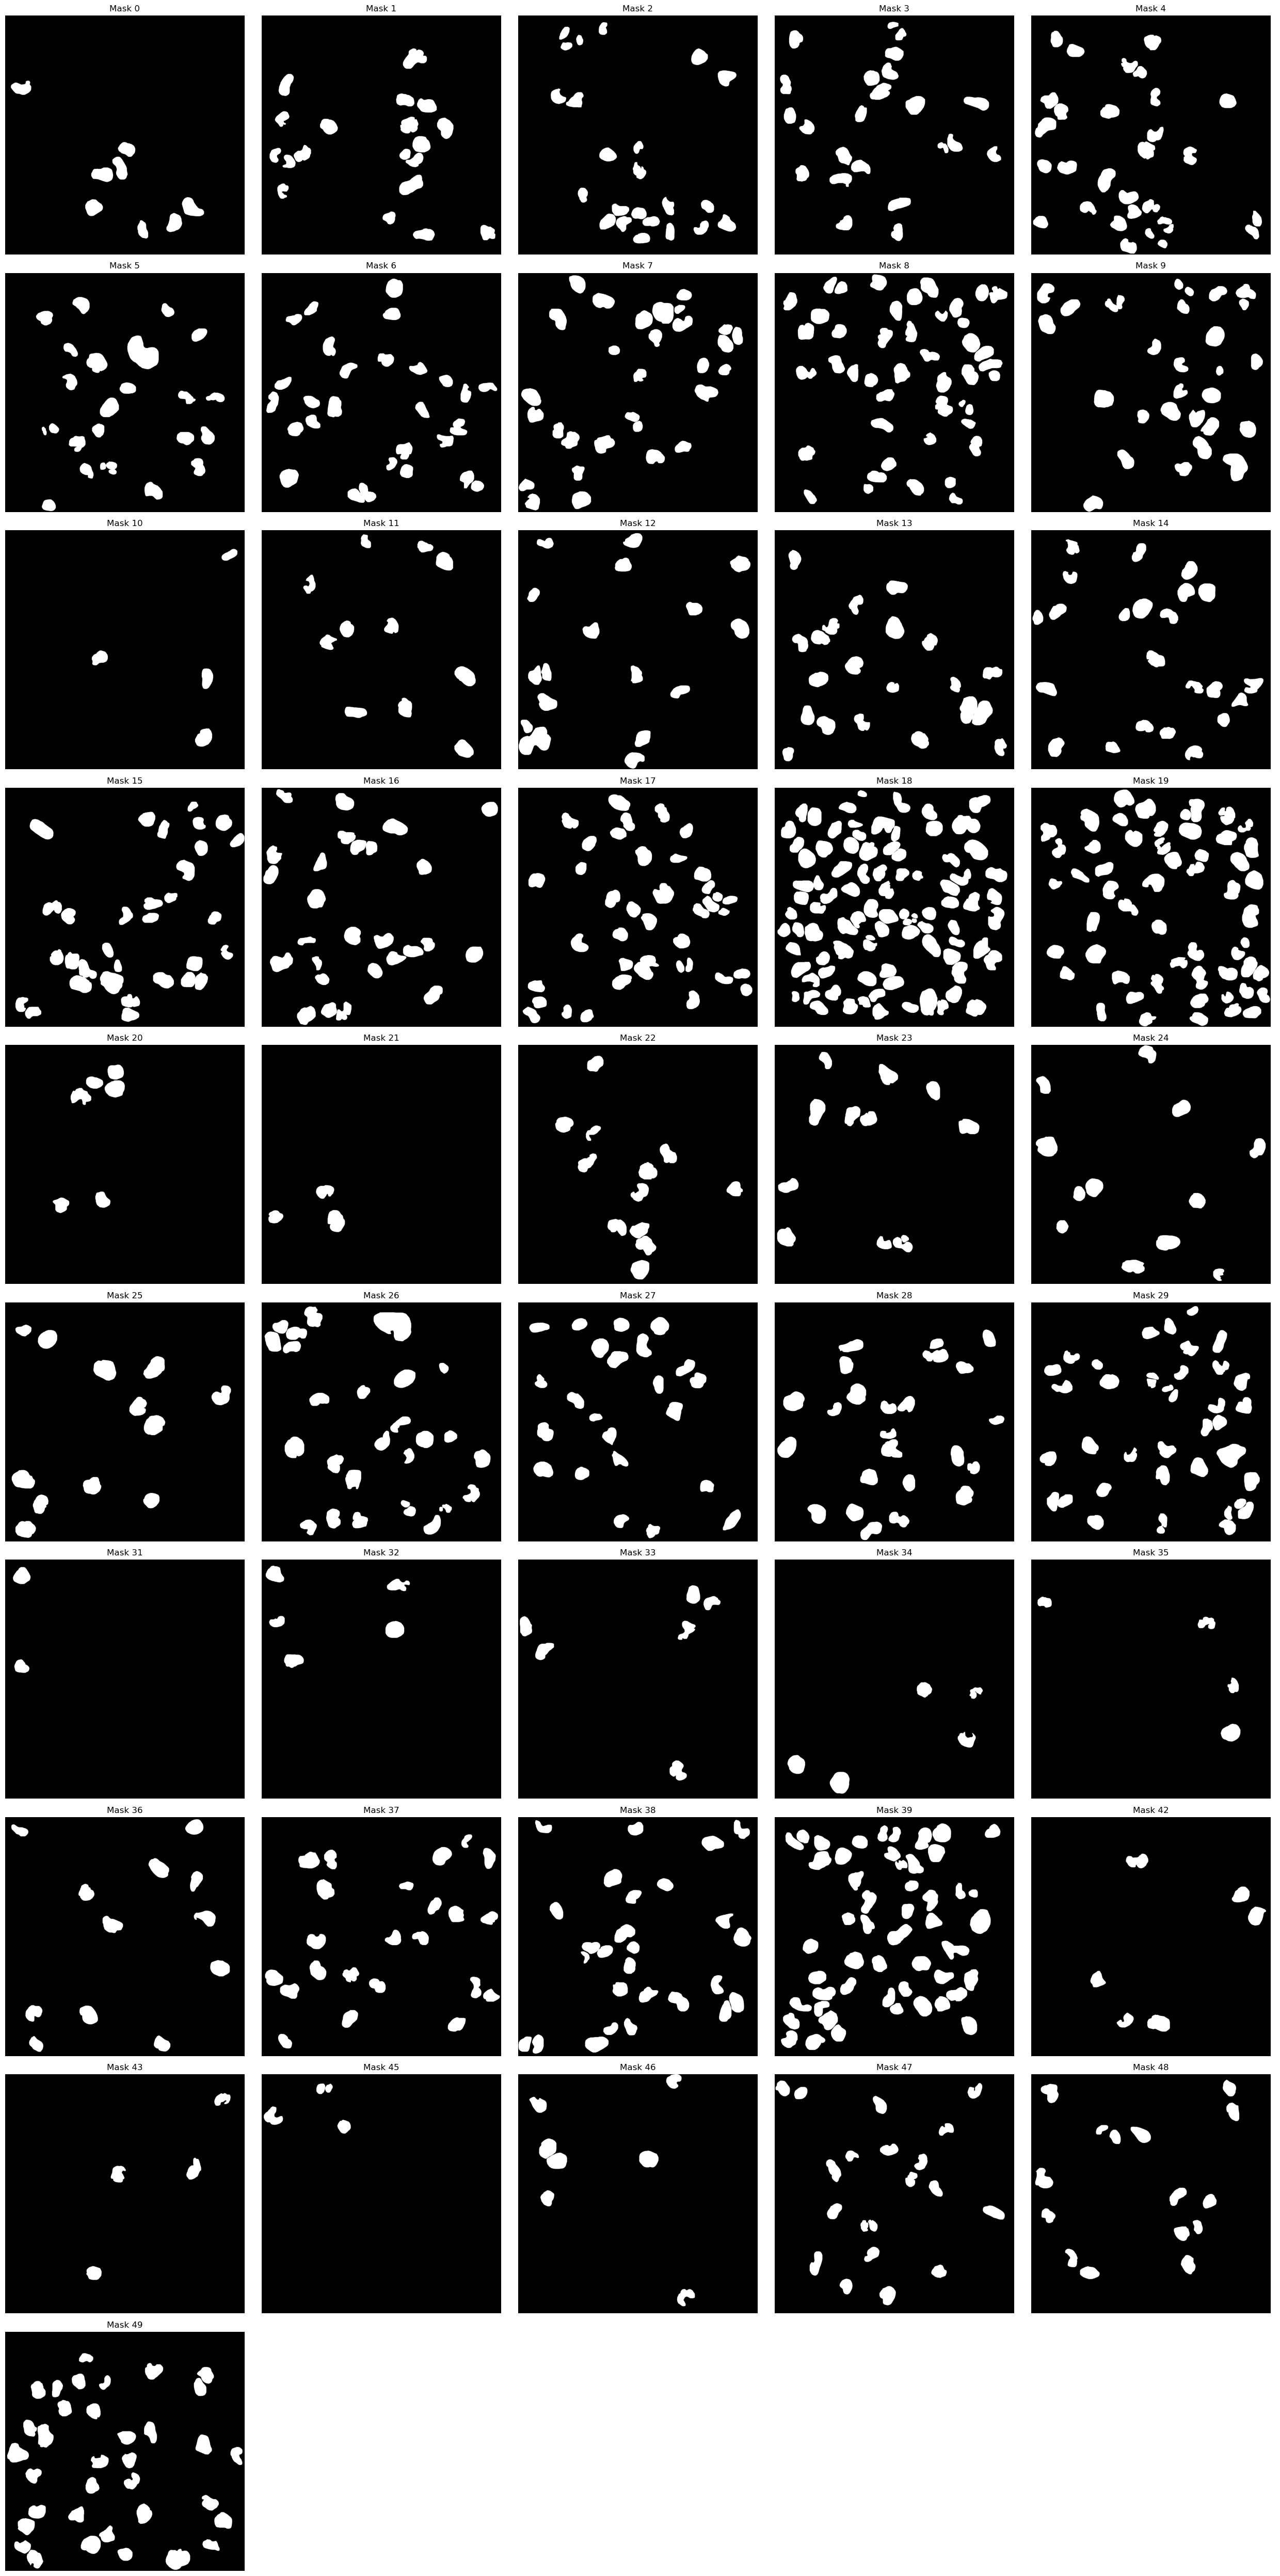

In [10]:
show_mat_data('51-100_Hong/51-100_finished.mat', 5, 'Tracked')

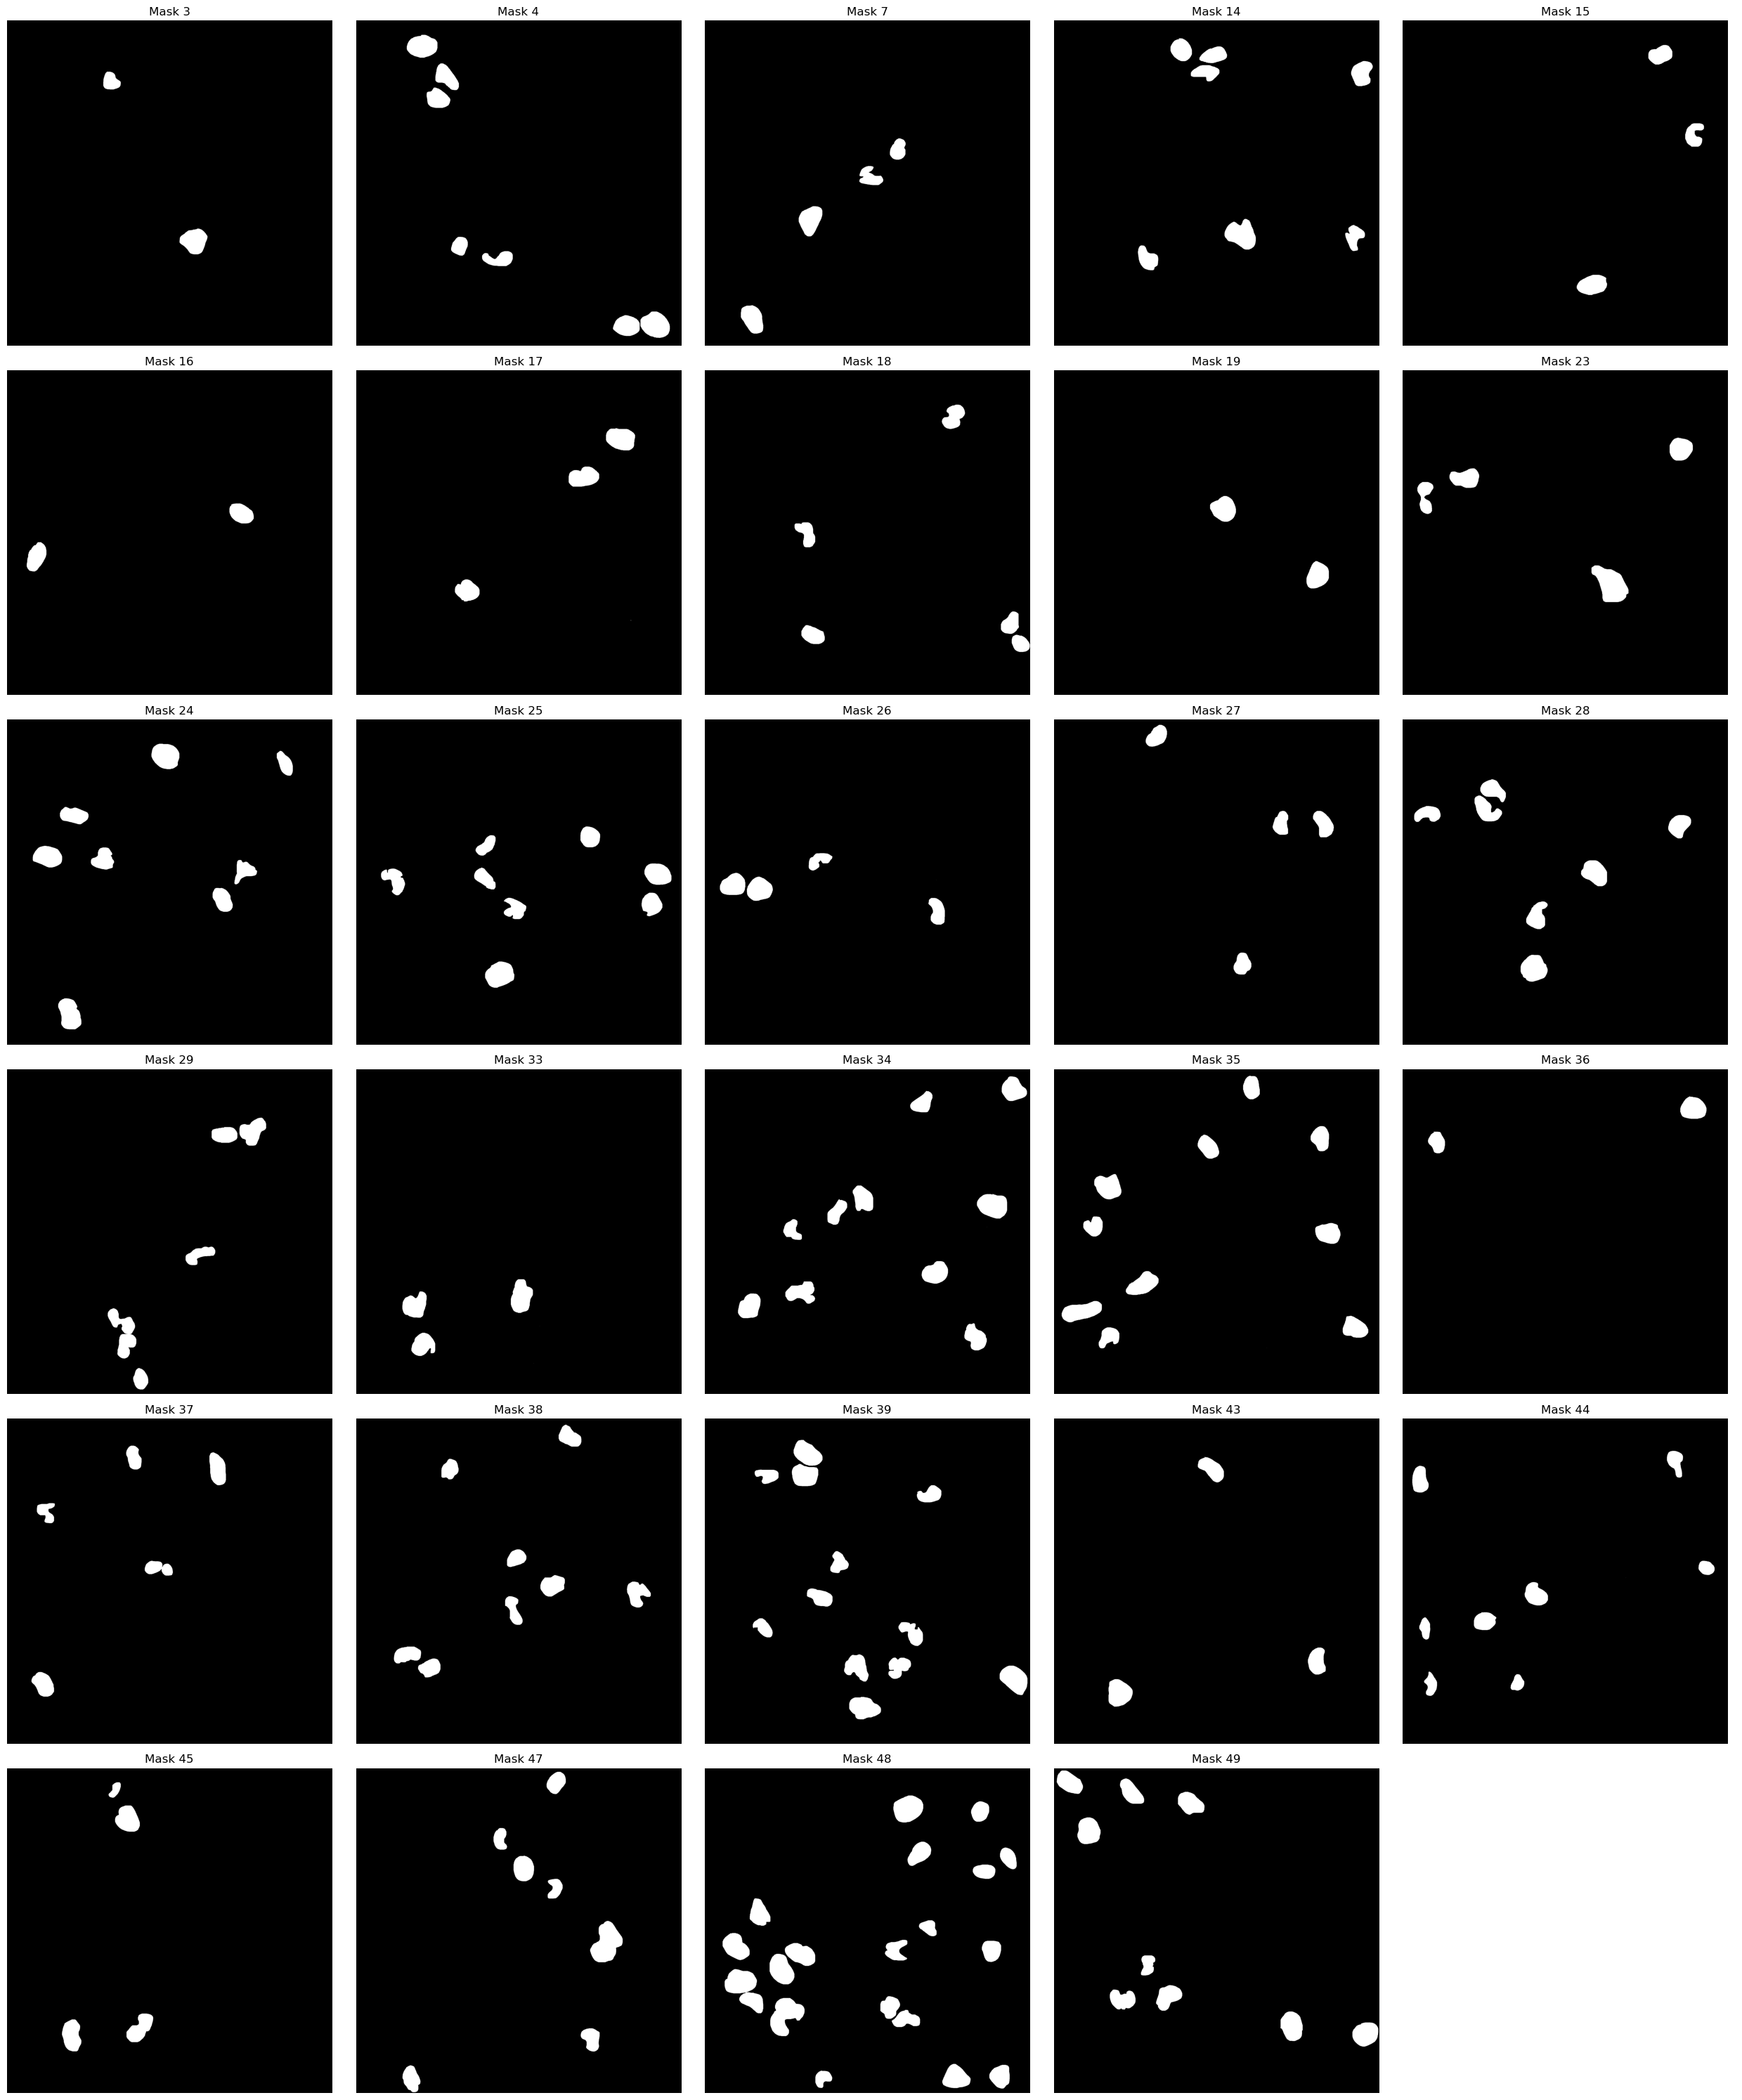

In [11]:
show_mat_data('151-200_Hong/151-200_finished.mat', 5, 'Tracked_151200')

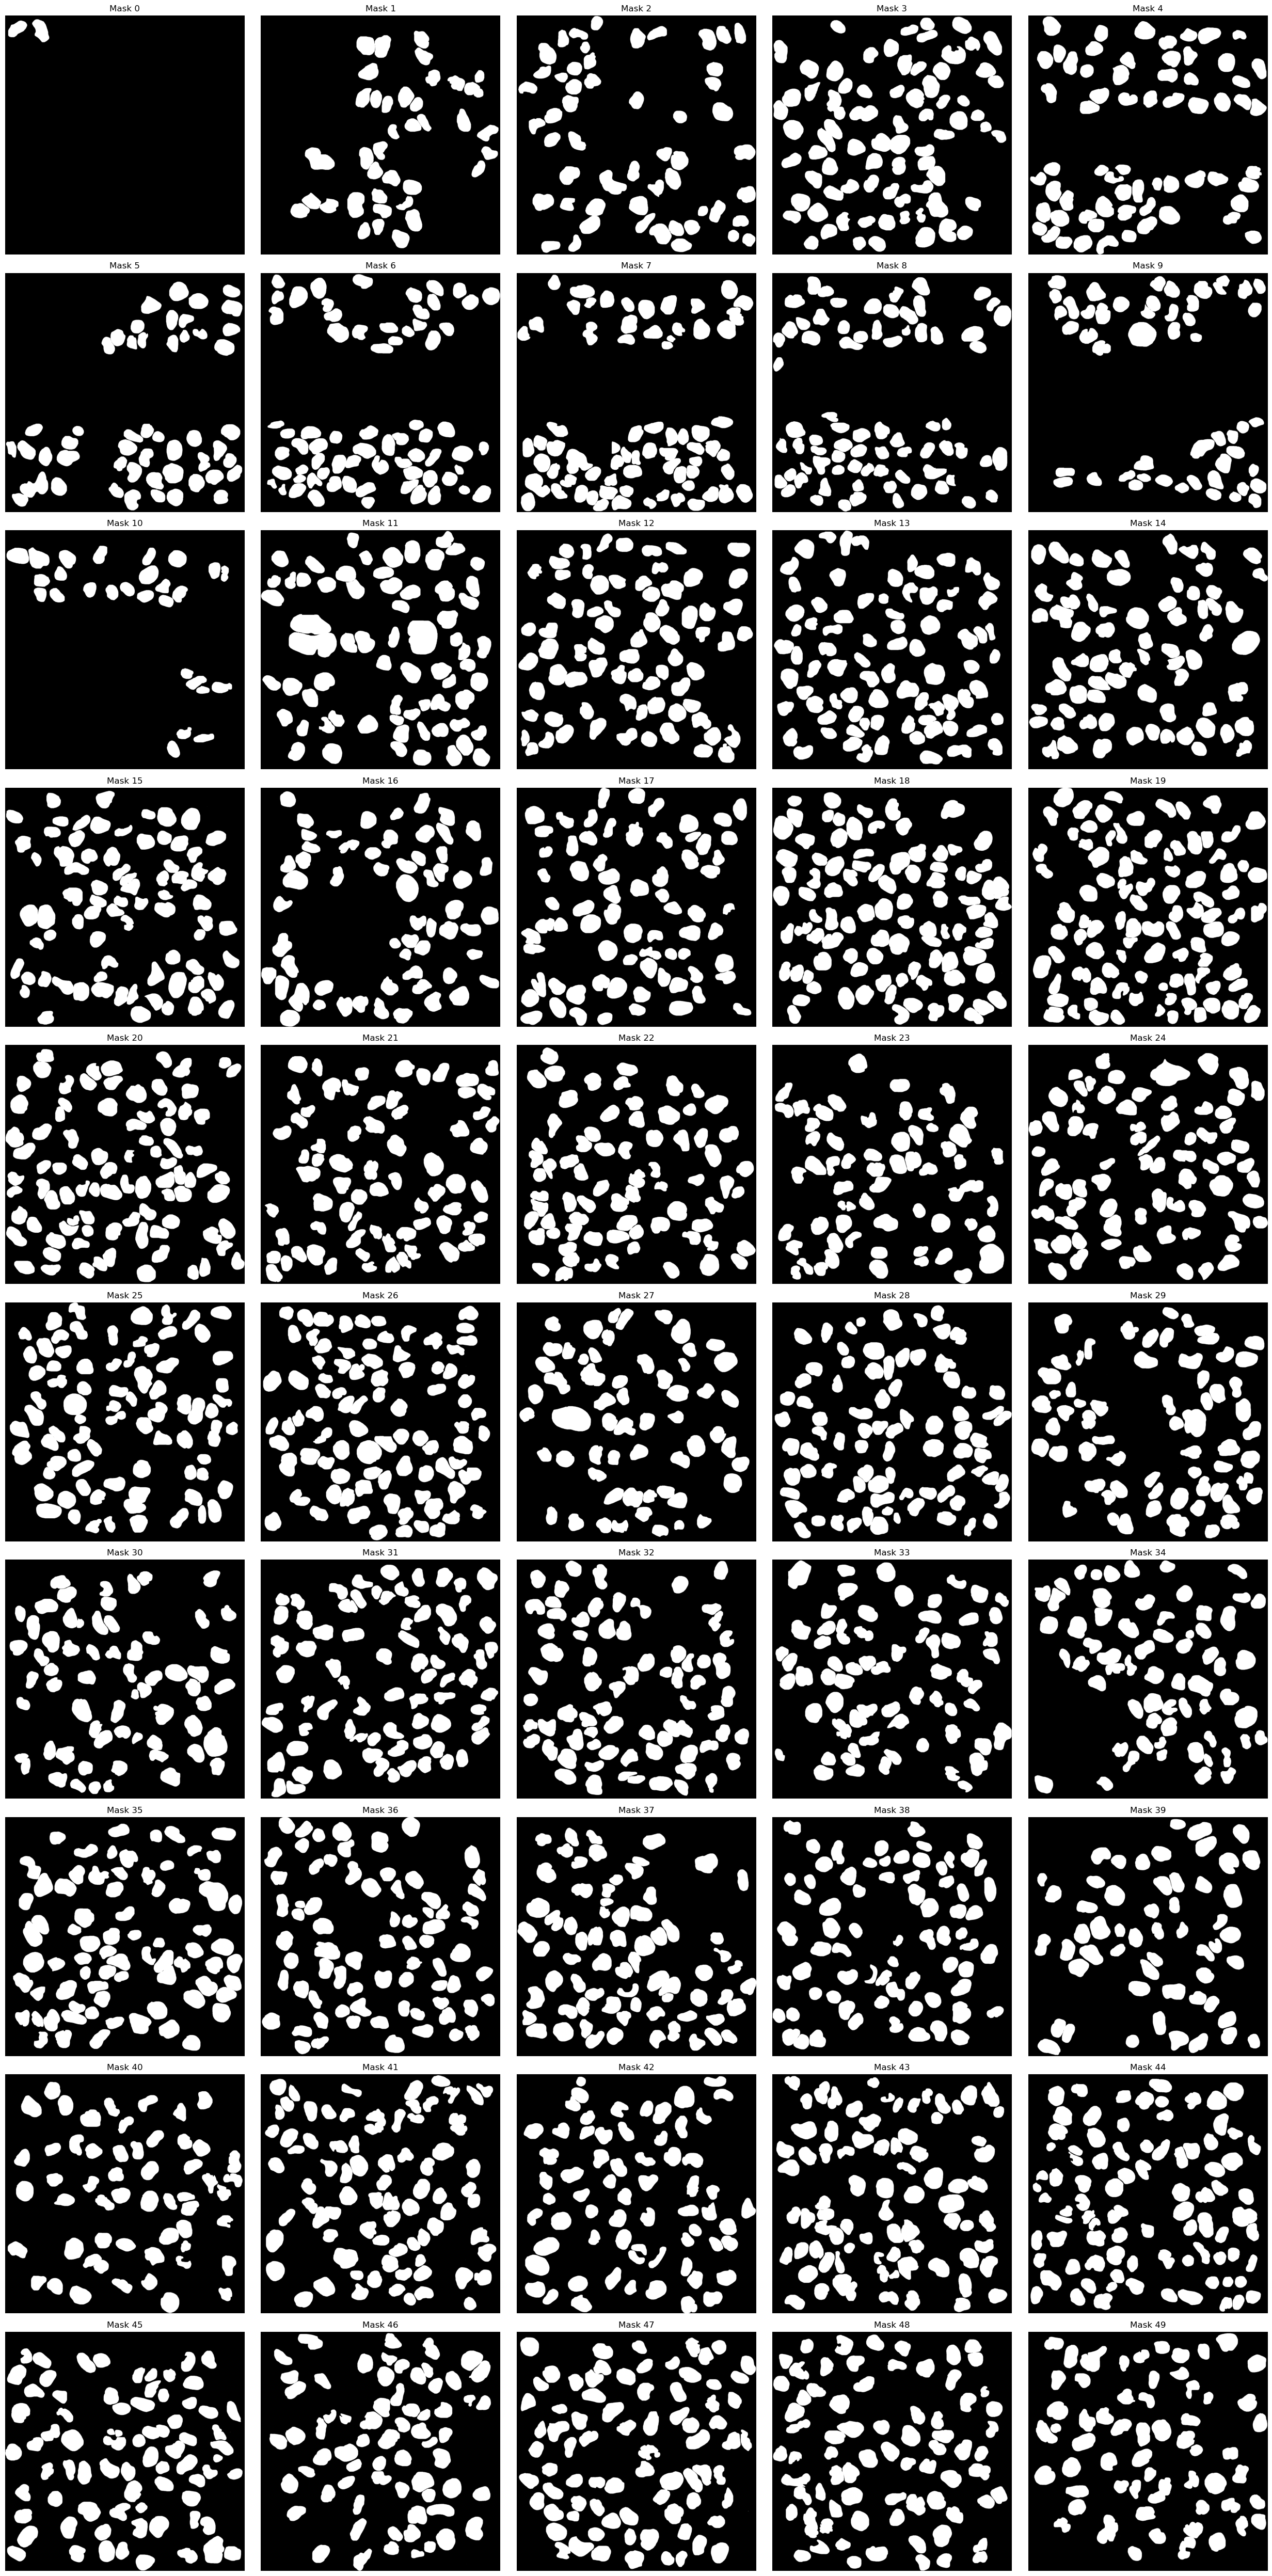

In [12]:
show_mat_data('201-250_Hong/201-250_finished.mat', 5, 'Tracked_201250')

In [39]:
images = get_tiffs_from_folder('201-250_Hong') # new func defined above
images.shape # 50 tiffs, each with 2048x2048 pixels

(50, 2048, 2048)

In [44]:
filtered_masks, valid_indices = get_masks_from_mat('201-250_Hong/201-250_finished.mat', 'Tracked_201250')
print(f"Masks cnt: {len(filtered_masks)}")
print(f"Masks index cnt: {len(valid_indices)}")
print(valid_indices)


Masks cnt: 50
Masks index cnt: 50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [45]:
filtered_images = images[valid_indices] # filters out the images that don't have masks

In [46]:
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Masks shape:", filtered_masks.shape)

Image shape: (50, 2048, 2048)
Masks shape: (50, 2048, 2048)


In [47]:
# Convert the NumPy arrays to 'uint8' and then to Pillow images, storing them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img.astype(np.uint8)) for img in filtered_images],
    "label": [Image.fromarray(mask.astype(np.uint8)) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [48]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50
})

'mask' is renamed as 'label' for training purposes

Make sure that images and labels are aligned

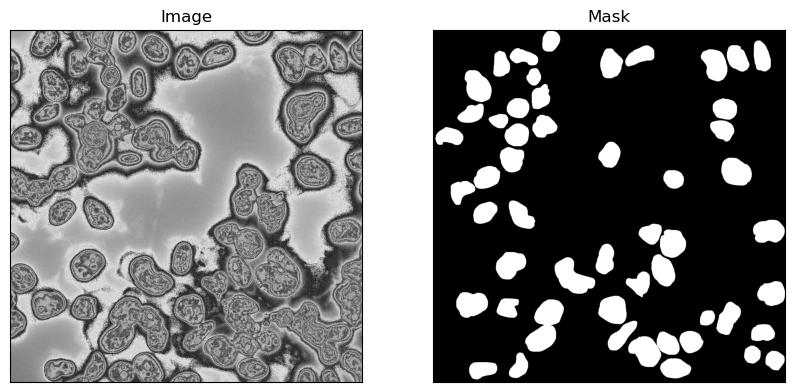

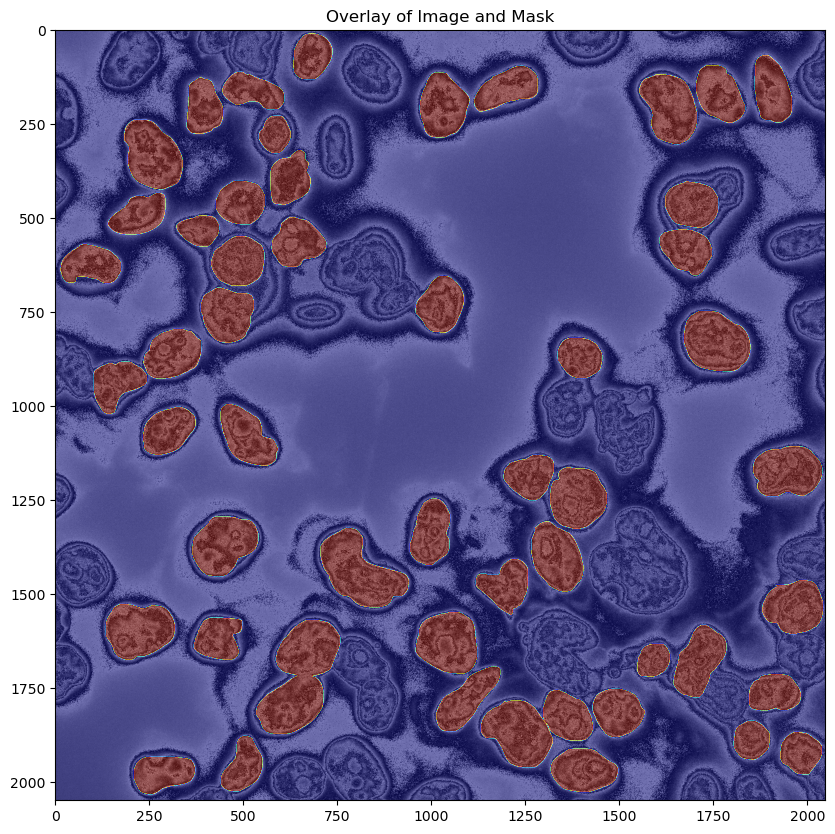

In [57]:
img_num = 2  # Change this to view a different image
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

plot_mask_on_image(np.array(example_image), example_mask)

Get bounding boxes from masks.

In [66]:
def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [74]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [75]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained('sam_vit_h_4b8939')
# I think here it might be the checkpoint path, not sure.

OSError: sam_vit_h_4b8939 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`